In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
np.random.seed()

In [3]:
def display_experimental_avg(arr,title):
    plt.hist(arr,color = 'purple')
    plt.title(title)
    print(np.nanmean(arr))

In [4]:
def generate_random_from_cumulative_dist(values_dict):
    random_number = np.random.rand()
    for key, value in values_dict.items():
        if random_number <= value:
            return key

In [5]:
def input_probability_distribution():
    lhs = []
    probabilities = []
    
    while True:
        lhs_value = float(input("Enter a value (or -1 to stop): "))
        if lhs_value == -1:
            break
        prob = float(input(f"Enter the probability for this value {lhs_value}: "))
        lhs.append(lhs_value)
        probabilities.append(prob)

    if not np.isclose(sum(probabilities), 1.0):
        raise ValueError("The sum of probabilities must be 1.")

    cumulative_probabilities = np.cumsum(probabilities).tolist()
    #returns a dictionary with key -> t and value -> c, from two combined iteratables LHS, and Cumulative Probabilites
    return {t: c for (t, c) in zip(lhs, cumulative_probabilities)}

In [6]:
rooms_dict = {1:0.1, 2: 0.25, 3:0.6, 4:0.8, 5:1}

lead_time_dict = {1:0.4, 2:0.75, 3:1}

choice = int(input("Choose 1 to enter new probability distributions: "))

if choice == 1:
    print("Enter probability distribution for the number of rooms occupied")
    rooms_dict = input_probability_distribution()
    print("Enter probability distribution for the lead time")
    lead_time_dict = input_probability_distribution()


Choose 1 to enter new probability distributions:  0


In [7]:
# Simulation parameters
number_of_runs = int(input("Enter number of Runs: "))
days = int(input("Enter number of days: "))
review_period = int(input("Enter the cycle length: "))

first_floor_max_capacity = int(input("Enter the first floor maximum capacity: "))
initial_first_floor_inventory = int(input("Enter the first floor initial capacity: "))

basement_max_capacity = int(input("Enter the basement maximum capacity: "))
initial_basement_inventory = int(input("Enter the basement initial capacity: "))

#  Cycle Length = 6
#  First Floor Max Capacity = 10
#  First Floor initial Capacity = 4
#  Basement Inventory Max Capacity = 30
#  Basement Inventory initial Capacity = 30

Enter number of Runs:  1000
Enter number of days:  1000
Enter the cycle length:  6
Enter the first floor maximum capacity:  10
Enter the first floor initial capacity:  4
Enter the basement maximum capacity:  30
Enter the basement initial capacity:  30


In [8]:
# Experimental Averages
demand_averages = []
lead_time_averages = []
shortage_days_average = []

for r in range(number_of_runs):
    # Simulation Table Columns
    cycle_col = [0] * (days + 1)
    day_col = [0] * (days + 1)
    rooms_occupied = [0] * (days + 1)
    first_floor_start = [0] * (days + 1)
    basement_start = [0] * (days + 1)
    first_floor_end = [0] * (days + 1)
    basement_end = [0] * (days + 1)
    transferred = [0] * (days + 1)
    shortage = [0] * (days + 1)
    lead_time = [0] * (days + 1)
    order_quantity_col = [0] * (days + 1)
    lead_time_remaining = [0]
    
    # In the dummy row we don't do any operations so we end with what we start
    first_floor_end[0] = initial_first_floor_inventory
    basement_end[0] = initial_basement_inventory

    # Order Variables
    current_order_quantity = 0
    order_arrives_at_day = 0

    # simulation for one table
    for day in range(1, days + 1):
        if day == order_arrives_at_day:
            basement_start[day] = basement_end[day - 1] + current_order_quantity

        cycle = (day - 1) // review_period + 1
        cycle_col[day] = cycle
        day_col[day] = day
        
        # Generate number of rooms occupied (independant)
        demand = generate_random_from_cumulative_dist(rooms_dict)
        rooms_occupied[day] = demand

        # Record starting inventories - ببدأ باللي انتهيت بيه, و البيزمنت بتبدأ باللي انتهت بيه + كمية الاوردر في حالة انه هيوصل النهاردة
        first_floor_start[day] = first_floor_end[day - 1]
        if day != order_arrives_at_day:
            basement_start[day] = basement_end[day - 1]

        # لو اللي موجود في الدور الاول هيكفي خد منه وخلاص 
        if demand <= first_floor_start[day]:
            first_floor_end[day] = first_floor_start[day] - demand
            basement_end[day] = basement_start[day]
        else:
            #Quantity = المتبقي عشان الفيرست فلور يتملي
            quantity = first_floor_max_capacity - first_floor_start[day]
            
            #Q_Transferred = الكمية اللي هاخدها من البيزمنت 
            q_transferred = min(quantity, basement_start[day])
            
            #transferred[day] = الكمية اللي خدتها من البيزمنت في اليوم ده
            transferred[day] = q_transferred
            
            #First_Floor_Start += اللي خدته من البيزمنت
            first_floor_start[day] += q_transferred
            
            #Basement_end -= اللي خدته منها
            basement_end[day] = basement_start[day] - q_transferred
            
            # لو اللي موجود في الدور الاول بعد ما خدنا من الدور الارضي هيكفي خد منه وخلاص
            # لأن ممكن اللي طلبناه من البيزمنت + اللي عندنا يكون اقل برضو من الديماند لو البيزمنت علي الحديدة
            if demand <= first_floor_start[day]:
                first_floor_end[day] = first_floor_start[day] - demand
                basement_start[day] = basement_end[day-1]
            #لو غير كدة يبقي مش هقدر اوفي الاحتياجات و هيبقي في عجز
            else:
                #مقدار العجز
                remaining_demand = demand - first_floor_start[day]
                first_floor_end[day] = 0
                basement_end[day] = 0
                # there is shortage in this day
                shortage[day] = remaining_demand

        lead_time_remaining.append(lead_time_remaining[day - 1])
        #يوم الريفيو
        if day % review_period == 0:
            #كمية الاوردر = المتبقي عشان نملأ البيزمنت 
            current_order_quantity = basement_max_capacity - basement_end[day]
            order_quantity_col[day] = current_order_quantity
            #اعمل جينيريشن لزمن وصول الاوردر 
            lead_time[day] = generate_random_from_cumulative_dist(lead_time_dict)
            #اليوم اللي هيوصل فيه الاوردر
            order_arrives_at_day = lead_time[day] + day + 1
            lead_time_remaining[day] = (lead_time[day]) + 1
        #افضل نقص الزمن المتبقي علي الوصول كل يوم, متخافش لو بقي بالسالب عشان هنشيلهم تحت
        lead_time_remaining[day] -= 1

        

    
    # Demand Average per run = sum of demand / number of days
    demand_averages.append(sum(rooms_occupied[1:])/days)
    #lead time average per run = sum of lead time / number of cycles
    lead_time_averages.append(sum(lead_time[1:])/(days//review_period))
    shortage_days_average.append(sum(1 if i > 0 else 0 for i in shortage[1:]))
    # shortage_days_average.append(sum(1.0 if i > 0 else 0.0 for i in shortage[1:])/days*1.0)

In [9]:
print(f"Experimental Average of the lead time is : {np.mean(lead_time_averages)}")
print(f"Experimental Average of the demand is : {np.mean(demand_averages)}")
print(f"number of days when shortage occurs For Last Simulation: {sum(1 if i > 0 else 0 for i in shortage[1:] )} days")

Experimental Average of the lead time is : 1.847277108433735
Experimental Average of the demand is : 3.2502970000000007
number of days when shortage occurs For Last Simulation: 6 days


1.847277108433735


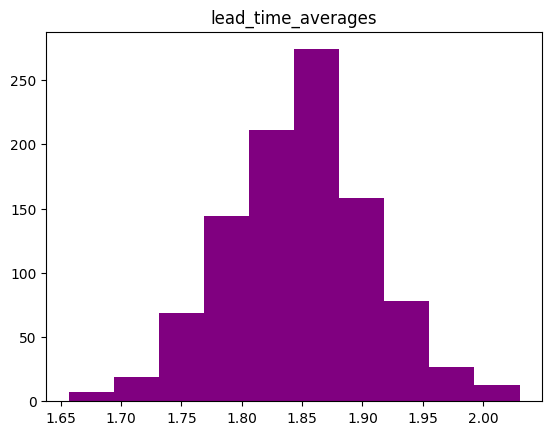

In [10]:
display_experimental_avg(lead_time_averages,'lead_time_averages')

3.2502970000000007


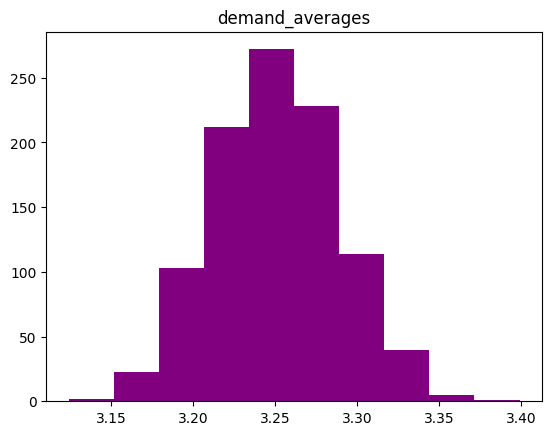

In [11]:
display_experimental_avg(demand_averages,'demand_averages')

7.613


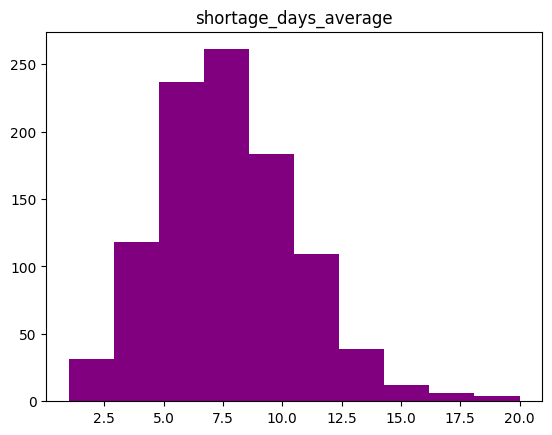

In [12]:
display_experimental_avg(shortage_days_average,'shortage_days_average')

In [13]:
# Remove -ve Values from Lead Time Remaining
lead_time_remaining[1:] = [max(0, value) for value in lead_time_remaining[1:]]

# Construct the simulation table
simulation_table = {
        "Cycle": cycle_col[1:],
        "Day": day_col[1:],
        "Rooms Occupied": rooms_occupied[1:],
        "1st Floor (Start)": first_floor_start[1:],
        "1st Floor (End)": first_floor_end[1:],
        "Basement (Start)": basement_start[1:],
        "Boxes Transferred from Basement": transferred[1:],
        "Basement (End)": basement_end[1:],
        "Shortage Quantity": shortage[1:],
        "Lead Time": lead_time[1:],
        "Order Quantity": order_quantity_col[1:],
        "Days Until Order Arrive": lead_time_remaining[1:]
    }

# Convert to DataFrame for tabular display
simulation_df = pd.DataFrame(simulation_table)

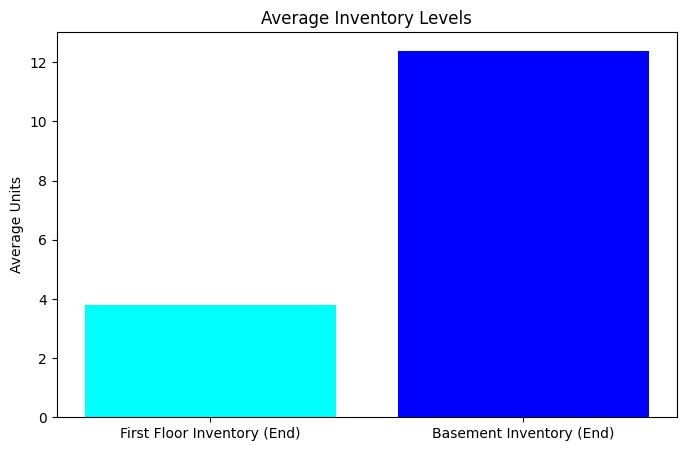

[3.792207792207792, 12.395604395604396]


In [14]:
# Calculate averages
avg_first_floor_end = sum(first_floor_end) / len(first_floor_end)
avg_basement_end = sum(basement_end) / len(basement_end)

# Prepare data for plotting
categories = ['First Floor Inventory (End)', 'Basement Inventory (End)']
averages = [avg_first_floor_end, avg_basement_end]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(categories, averages, color=['cyan', 'blue'])
plt.title('Average Inventory Levels')
plt.ylabel('Average Units')
plt.show()
print(averages)

[6, 994]


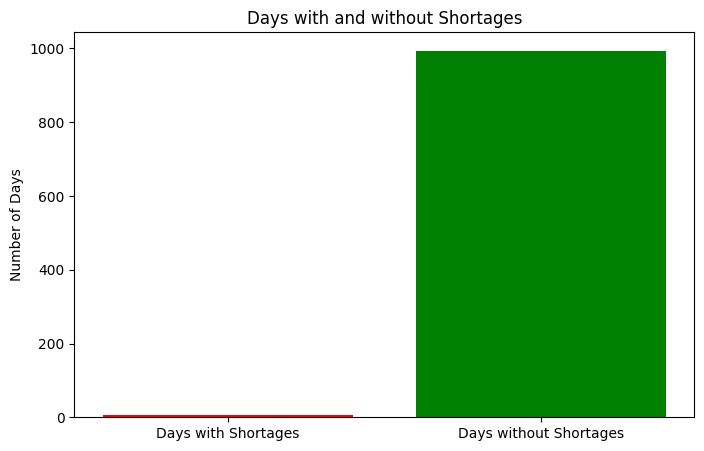

In [15]:
days_with_shortages = sum(1 for s in shortage[1:] if s > 0)
days_without_shortages = len(shortage[1:]) - days_with_shortages

# Prepare data for plotting
categories = ['Days with Shortages', 'Days without Shortages']
values = [days_with_shortages, days_without_shortages]
print(values)

# Plot
plt.figure(figsize=(8, 5))
plt.bar(categories, values, color=['red', 'green'])
plt.title('Days with and without Shortages')
plt.ylabel('Number of Days')
plt.show()

In [16]:
simulation_df.to_excel("Problem2Output.xlsx",index = False)